# Lab 1: Implement Feedforward Neural Network

## 2113615 张铭徐

### Experiment requirments:

- Master the basic principles of feedforward neural networks (FFN).
- Learn to build simple FFNs using PyTorch to classify the MNIST dataset.
- Understand how to improve network structure and tune parameters to enhance network recognition performance.

### Basic principles of FFN

A Feedforward Neural Network (FFN) is a type of artificial neural network where connections between the nodes do not form a cycle. This is one of the simplest forms of neural network architectures and serves as the foundation for many more complex models. The FFN consists of an input layer, one or more hidden layers, and an output layer. Here's a brief overview of its components and how it works:

### Input Layer
- **Receives input signals**: This layer consists of neurons (nodes) that receive input features and pass them to the next layer without performing any computation on them. Each neuron in the input layer represents one feature in the input data.

### Hidden Layers
- **Perform computations**: One or more hidden layers perform computations on the inputs received from the previous layer using weighted connections and transfer functions. These layers are where most of the processing happens through neurons that apply activation functions to their inputs.
- **Activation Functions**: Functions like ReLU (Rectified Linear Unit), Sigmoid, or Tanh are used in these layers to introduce non-linearity to the model, allowing it to learn complex patterns.

### Output Layer
- **Produces the final output**: The last layer of a feedforward neural network. It brings the data from the network's complex internal representation down to the form in which we want our output (e.g., probabilities for classification tasks).

### Learning Process
- **Backpropagation**: Although the network is called "feedforward" because information moves forward from the input to the output layer, the network learns using a method called backpropagation. In backpropagation, the error between the predicted output and the actual output is calculated, and this error is used to adjust the weights of the connections between nodes, moving from the output layer back towards the input layer.
- **Gradient Descent**: This optimization algorithm is used to minimize the error by updating the weights in the direction that decreases the error the most efficiently.

FFNs are widely used in various applications, including image and speech recognition, classification tasks, and many others where the goal is to learn a mapping from inputs to outputs.

In this Notebook,we will use MLP to do image classification in MNIST,and try to use different settings to find the best hyperparameters.Additional,we will try to implement the ResMLP using PyTorch.

In [125]:
# import neccessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
from datasets import load_dataset
import torch
import torch.nn.parallel
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

In [126]:
# Load MNIST.npz
mnist = np.load('./data/mnist.npz')
x_train = mnist['x_train']
y_train = mnist['y_train']
x_test = mnist['x_test']
y_test = mnist['y_test']

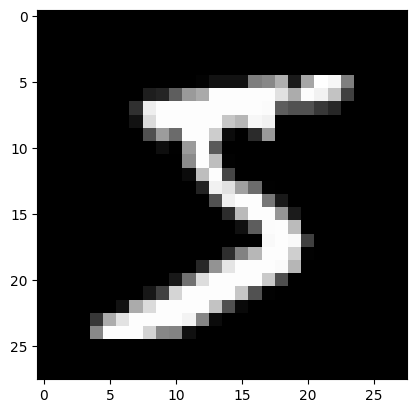

5

In [127]:
# show the first image
plt.imshow(x_train[0], cmap='gray')
plt.show()
y_train[0]

In [128]:
# output the image size
print(x_train.shape)

(60000, 28, 28)


In [129]:
# count all the labels from the training set
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


### We can see that the MNIST dataset is a dataset of 28x28 images of handwritten digits and contains a training set of 60,000 examples and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.And the amount of each labels is balanced.

## MLP implementation

We have created the miniconda environment and installed the required packages. And we have installed the GPU version of PyTorch. So we can use the GPU to accelerate the training process.

### GPU check

First, we need to check if the GPU is available and if it is being used by PyTorch.

In [151]:
# test GPU,output the amount of GPU and the name of the GPU
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
8
NVIDIA GeForce RTX 3090


## Implementing a Feedforward Neural Network using PyTorch

GPU can be used to accelerate the training process. We can use the `torch.cuda.is_available()` method to check if a GPU is available and the `torch.cuda.current_device()` method to check which GPU is being used.

We will implement two version of MLP, one will use single GPU and the other will use multiple GPUs.And we will compare the training time of these two versions.

### Single GPU version
In this version, we can change different settings to train model, including optimizer, learning rate, batch size. And we will compare different accuracy of each settings to find the best hyperparameters. In the end, we will analyze the results and try to explain the reasons.

### Multiple GPUs version
In this version, we will use `torch.nn.DataParallel` to use multiple GPUs to train the model. And we will compare the training time of these two versions. And we will analyze the results and try to explain the reasons.

### Stable Setting
We will use the following setting to train the model:
- output layer's activate function: softmax: The softmax function is used to normalize the output of a network to a probability distribution over predicted output classes. The output of the softmax function is equivalent to a categorical probability distribution, it tells you the probability that any of the classes are true. The fuction is defined as:

    $$f(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}$$

    $x$ is the input vector, and $n$ is the number of classes. The output of the softmax function is a vector that contains the probability that each class is true.

    e.g. if the input vector is [1, 2, 3, 4], the output of the softmax function will be [0.0321, 0.0871, 0.2369, 0.6439]. Which means the probability of class 1 is 0.0321, the probability of class 2 is 0.0871, and so on.

- epochs: 10. The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches. For example, as above, an epoch that has one batch is called the batch gradient descent learning algorithm.

- loss function: nll_loss. The negative log likelihood loss. It is useful to train a classification problem with C classes. If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.The function is defined as:

    
    $$loss = -log(p(y)) $$

    where $p(y)$ is the probability of the true class.

In [130]:
# define a MLP class using pytorch-GPU
class Net_single_GPU(nn.Module):
    '''
    We define a class called Net_single_GPU, which is a subclass of nn.Module.
    The class has three layers, the input layer, the hidden layer, and the output layer.
    The input layer has 28*28 neurons, the hidden layer has 128 neurons, and the output layer has 10 neurons.
    Because the mnist is 28*28 images, so the input layer has 28*28 neurons, and the output layer has 10 neurons 
    because there are 10 labels in the mnist dataset.
    '''
    def __init__(self):
        super(Net_single_GPU, self).__init__()
        # input layers
        self.fc1 = nn.Linear(28*28, 128)
        # hidden layers
        self.fc2 = nn.Linear(128, 128)
        # output layers 
        self.fc3 = nn.Linear(128, 10)

    # define the forward function
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # use log_softmax as the activation function in order to get the probability of each label
        return F.log_softmax(x, dim=1)

    def train(self, x_train, y_train, epochs=10, lr=0.001, optimizer=optim.SGD, batch_size=100):
        '''
        We define a train function, which is used to train the model.
        In this function, we can use different optimizers, such as SGD, Adam, Adagrad, and RMSprop.
        We can also set the learning rate, the number of epochs, and the batch size.
        But we only test the optimizers, learning rates, and batch sizes in the following experiments.
        
        learning rate means the step size at each iteration while moving toward a minimum of a loss function.
        batch size means the number of training examples utilized in one iteration
        we will continue sampling the training examples in the dataset
        and we will continue to train the model until we have used all the training examples.
        '''
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        if optimizer == optim.SGD:
            optimizer = optim.SGD(self.parameters(), lr)
        if optimizer == optim.Adam:
            optimizer = optim.Adam(self.parameters(), lr)
        if optimizer == optim.Adagrad:
            optimizer = optim.Adagrad(self.parameters(), lr)
        if optimizer == optim.RMSprop:
            optimizer = optim.RMSprop(self.parameters(), lr)
        losses = []
        epoches = []
        min_loss = 1000
        times = 0
        for epoch in range(epochs):
            for i in range(0, len(x_train), batch_size):
                x = torch.tensor(x_train[i:i+batch_size], dtype=torch.float32).to(device)
                y = torch.tensor(y_train[i:i+batch_size], dtype=torch.long).to(device)
                optimizer.zero_grad()
                output = self(x)
                loss = F.nll_loss(output, y)
                loss.backward()
                optimizer.step()
            if loss.item() < min_loss:
                min_loss = loss.item()
                times = 0
            else:
                print('Epoch', epoch, 'Loss', loss.item())
                if epoch != 0:
                    losses.append(loss.item())
                    epoches.append(epoch)
                times = times + 1
                # we set the threshold to 3, if the loss is not reduced for 3 times, we stop the training process.
                if times > 3:
                    break
            if epoch != 0:
                losses.append(loss.item())
                epoches.append(epoch)

            print('Epoch', epoch, 'Loss', loss.item())

    # show the loss
    def show_loss(epoches, losses):
        plt.plot(epoches, losses)
        plt.show()

    # test the model
    def test(self, x_test, y_test):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        correct = 0
        total = 0
        with torch.no_grad():
            for i in range(0, len(x_test), 100):
                x = torch.tensor(x_test[i:i+100], dtype=torch.float32).to(device)
                y = torch.tensor(y_test[i:i+100], dtype=torch.long).to(device)
                output = self(x)
                _, predicted = torch.max(output.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        print('Accuracy', correct/total)
        return correct/total
    
    def predict(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32).to(device)
            output = self(x)
            _, predicted = torch.max(output.data, 1)
            return predicted

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))


In [131]:
# Using Many-GPU to run
class Net_multi_GPU(nn.Module):
    def __init__(self):
        super(Net_multi_GPU, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def train(self, x_train, y_train, epochs=10, lr=0.001, optimizer=optim.SGD):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        if torch.cuda.device_count() > 1:
            print("Using", torch.cuda.device_count(), "GPUs!")
            # we use the DataParallel to use multiple GPUs
            self = nn.DataParallel(self)
        if optimizer == optim.SGD:
            optimizer = optim.SGD(self.parameters(), lr)
        if optimizer == optim.Adam:
            optimizer = optim.Adam(self.parameters(), lr)
        if optimizer == optim.Adagrad:
            optimizer = optim.Adagrad(self.parameters(), lr)
        if optimizer == optim.RMSprop:
            optimizer = optim.RMSprop(self.parameters(), lr)
        losses = []
        epoches = []
        min_loss = 1000
        for epoch in range(epochs):
            for i in range(0, len(x_train), 100):
                x = torch.tensor(x_train[i:i+100], dtype=torch.float32).to(device)
                y = torch.tensor(y_train[i:i+100], dtype=torch.long).to(device)
                optimizer.zero_grad()
                output = self(x)
                # We use the negative log likelihood loss
                loss = F.nll_loss(output, y)
                # backpropagation
                loss.backward()
                # update the weights
                optimizer.step()
            # we can use the min_loss to stop the training if the loss is not decreasing
            if loss.item() < min_loss:
                min_loss = loss.item()
            else:
                print('Epoch', epoch, 'Loss', loss.item())
                if epoch != 0:
                    losses.append(loss.item())
                    epoches.append(epoch)
                break
            if epoch != 0:
                losses.append(loss.item())
                epoches.append(epoch)
            
            print('Epoch', epoch, 'Loss', loss.item())
            
        # show the loss
        plt.plot(epoches, losses)
        plt.show()
        

    def test(self, x_test, y_test):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        correct = 0
        total = 0
        with torch.no_grad():
            for i in range(0, len(x_test), 100):
                x = torch.tensor(x_test[i:i+100], dtype=torch.float32).to(device)
                y = torch.tensor(y_test[i:i+100], dtype=torch.long).to(device)
                output = self(x)
                _, predicted = torch.max(output.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        print('Accuracy', correct/total)
    
    def predict(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32).to(device)
            output = self(x)
            _, predicted = torch.max(output.data, 1)
            return predicted

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))


In [132]:
# set the seed make sure the result is the same
torch.manual_seed(0)

<class 'torch.optim.sgd.SGD'>
Using 8 GPUs!
Epoch 0 Loss 0.3942856192588806
Epoch 1 Loss 0.3363320231437683
Epoch 2 Loss 0.3151586055755615
Epoch 3 Loss 0.30093586444854736
Epoch 4 Loss 0.2894279956817627
Epoch 5 Loss 0.280060738325119
Epoch 6 Loss 0.26699724793434143
Epoch 7 Loss 0.25471794605255127
Epoch 8 Loss 0.24531325697898865
Epoch 9 Loss 0.23694577813148499


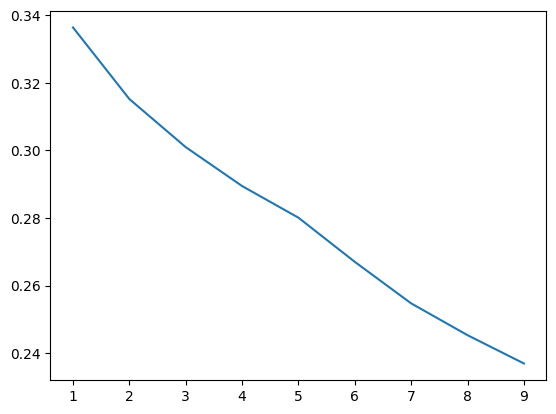

Accuracy 0.9635
<class 'torch.optim.adam.Adam'>
Using 8 GPUs!
Epoch 0 Loss 0.4519047141075134
Epoch 1 Loss 0.25062504410743713
Epoch 2 Loss 0.3025360703468323


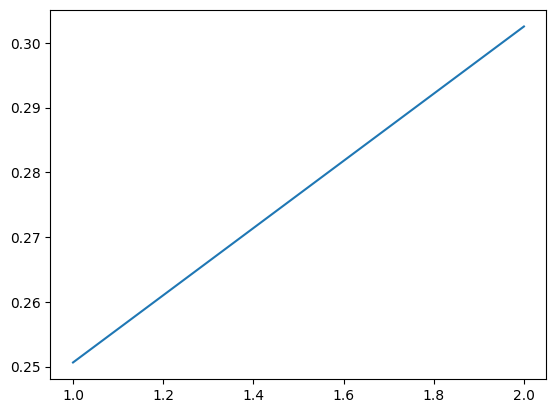

Accuracy 0.9619
<class 'torch.optim.adagrad.Adagrad'>
Using 8 GPUs!
Epoch 0 Loss 0.20969076454639435
Epoch 1 Loss 0.18586760759353638
Epoch 2 Loss 0.17354242503643036
Epoch 3 Loss 0.16490085422992706
Epoch 4 Loss 0.15844950079917908
Epoch 5 Loss 0.15387316048145294
Epoch 6 Loss 0.14886021614074707
Epoch 7 Loss 0.14476236701011658
Epoch 8 Loss 0.14124685525894165
Epoch 9 Loss 0.1372935026884079


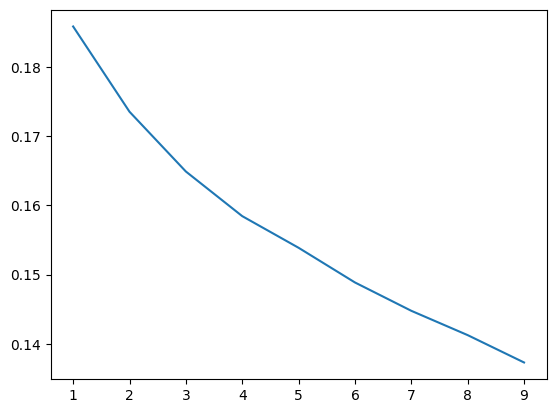

Accuracy 0.9779
<class 'torch.optim.rmsprop.RMSprop'>
Using 8 GPUs!
Epoch 0 Loss 0.5518629550933838
Epoch 1 Loss 0.25669267773628235
Epoch 2 Loss 0.2754879295825958


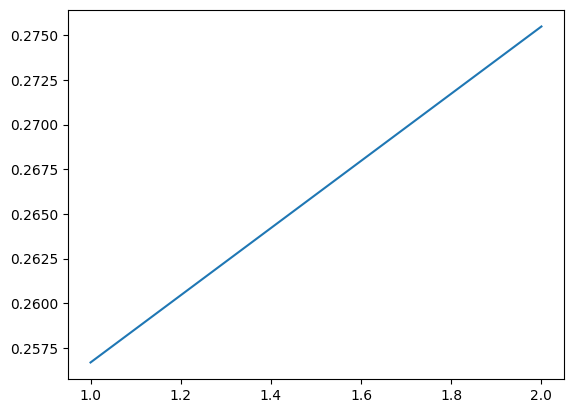

Accuracy 0.9548


In [133]:
# create a MLP model using many GPU
net = Net_multi_GPU()
# test all of the optimizers
optimizers = [optim.SGD, optim.Adam, optim.Adagrad, optim.RMSprop]
for optimizer in optimizers:
    print(optimizer)
    net.train(x_train, y_train, epochs=10, lr=0.001, optimizer=optimizer)
    net.test(x_test, y_test)

## results

The whole training time is 4min20s that train 4 models, we try four different optimizer, including SGD, Adam, Adagrad, RMSprop. And we find that the Adagrde optimizer has the best performance. The accuracy of the model is 0.9779.


The table of each optimizer's accuracy is shown below:

| Optimizer | Accuracy | Training Epochs | batch_size
|-----------|----------|-----------------|------------|
| SGD       | 0.9635   | 10              |  100       |
| Adam      | 0.9619   | 3               |  100       |
| **Adagrad**   | **0.9779**   | **10**  |  100       |
| RMSprop   | 0.9548   | 3               |  100       |


In [134]:
# define a function to test different settings
def test_settings(epochs, lr, optimizer, batch_size):
    net = Net_single_GPU()
    net.train(x_train, y_train, epochs=epochs, lr=lr, optimizer=optimizer, batch_size=batch_size)
    return net.test(x_test, y_test)

## different batch size, learning rate, and optimizer settings
In this part, we will try different batch size, learning rate, and optimizer settings to find the best hyperparameters.We will use single GPU to train the model.

- the learning rate will choose from 0.001, 0.005, 0.01, 0.05, 0.1
- the batch size will choose from 100, 200, 300, 400, 500
- the optimizer will choose from SGD, Adam, Adagrad, RMSprop

in other words,we will train 100 models to find the best hyperparameters.

In [135]:
# create a MLP model using single GPU
net = Net_single_GPU()
# test all of the optimizers
optimizers = [optim.SGD, optim.Adam, optim.Adagrad, optim.RMSprop]
# try different learning rates and batch sizes and optimizers to see the performance
lrs = [0.001, 0.005,0.01, 0.05, 0.1]
batch_sizes = [100, 200, 300, 400, 500]
#define a variable to store the results
results_MLP = []
for lr in lrs:
  for batch_size in batch_sizes:
    for optimizer in optimizers:
        net = Net_single_GPU()
        print(optimizer)
        print('lr:', lr)
        print('batch_size:', batch_size)
        acc = test_settings(10, lr, optimizer, batch_size)
        print('acc:', acc)
        results_MLP.append((optimizer, lr, batch_size, acc))
        # save the settings and results
        with open('results.txt', 'a') as f:
            f.write('optimizer: ' + str(optimizer) + ' lr: ' + str(lr) + ' batch_size: ' + str(batch_size) + ' accuracy: ' + str(acc) + '\n')

<class 'torch.optim.sgd.SGD'>
lr: 0.001
batch_size: 100
Epoch 0 Loss 0.29816392064094543
Epoch 1 Loss 0.25029894709587097
Epoch 2 Loss 0.23692601919174194
Epoch 3 Loss 0.22793376445770264
Epoch 4 Loss 0.23211677372455597
Epoch 4 Loss 0.23211677372455597
Epoch 5 Loss 0.23405298590660095
Epoch 5 Loss 0.23405298590660095
Epoch 6 Loss 0.23179373145103455
Epoch 6 Loss 0.23179373145103455
Epoch 7 Loss 0.23074458539485931
Accuracy 0.9581
acc: 0.9581
<class 'torch.optim.adam.Adam'>
lr: 0.001
batch_size: 100
Epoch 0 Loss 0.282279908657074
Epoch 1 Loss 0.21288946270942688
Epoch 2 Loss 0.18577724695205688
Epoch 3 Loss 0.19658786058425903
Epoch 3 Loss 0.19658786058425903
Epoch 4 Loss 0.11302702128887177
Epoch 5 Loss 0.2115587294101715
Epoch 5 Loss 0.2115587294101715
Epoch 6 Loss 0.23560558259487152
Epoch 6 Loss 0.23560558259487152
Epoch 7 Loss 0.08217376470565796
Epoch 8 Loss 0.10880020260810852
Epoch 8 Loss 0.10880020260810852
Epoch 9 Loss 0.10012256354093552
Epoch 9 Loss 0.10012256354093552
Accu

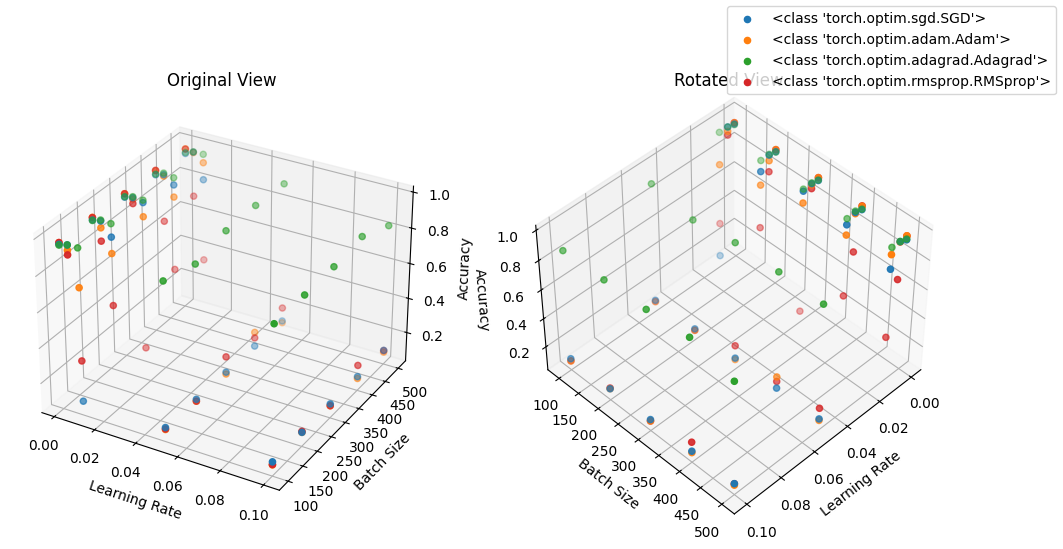

In [136]:
# show the results using figure
results_MLP = np.array(results_MLP)
fig = plt.figure(figsize=(12, 6))

# First subplot with the original view
ax1 = fig.add_subplot(121, projection='3d')
for optimizer in optimizers:
    mask = results_MLP[:, 0] == optimizer
    ax1.scatter(results_MLP[mask, 1], results_MLP[mask, 2], results_MLP[mask, 3], label=str(optimizer))
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Batch Size')
ax1.set_zlabel('Accuracy')
ax1.title.set_text('Original View')

# Second subplot with the rotated view
ax2 = fig.add_subplot(122, projection='3d')
for optimizer in optimizers:
    mask = results_MLP[:, 0] == optimizer
    ax2.scatter(results_MLP[mask, 1], results_MLP[mask, 2], results_MLP[mask, 3], label=str(optimizer))
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Batch Size')
ax2.set_zlabel('Accuracy')
ax2.view_init(elev=45, azim=45)
ax2.title.set_text('Rotated View')

# Create a legend for the whole figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.show()

## result analysis

we can see the figure below. The figure show the accuracy of each optimizer with different learning rate and batch size. The x-axis is the learning rate, and the y-axis is the batch size. The color of the point is the accuracy of the model. we can see some points have lower accuracy. We can check the result.txt and find that some of the settings lead to accuracy lower than 0.5.

The time is 380s, we train 100 models, which means we only need 3.8s to train a model. The time is acceptable.But the multiple GPU need 280s to train 4 models, which means we need 70s to train a model. The time is not acceptable. So we can see that the single GPU is faster than the multiple GPU in this case. The reason is that the model is not complex enough to use multiple GPUs to accelerate the training process. But the multiple GPUs need to communicate with each other, which will cost some time.

In [156]:
## find the result_MLP acc lower than 0.5
mask = results_MLP[:, 3] < 0.5
results_MLP[mask]
# sorted by optimizer


array([[<class 'torch.optim.sgd.SGD'>, 0.01, 100, 0.1135],
       [<class 'torch.optim.rmsprop.RMSprop'>, 0.01, 100, 0.3443],
       [<class 'torch.optim.rmsprop.RMSprop'>, 0.01, 300, 0.1135],
       [<class 'torch.optim.rmsprop.RMSprop'>, 0.01, 400, 0.429],
       [<class 'torch.optim.rmsprop.RMSprop'>, 0.01, 500, 0.3454],
       [<class 'torch.optim.sgd.SGD'>, 0.05, 100, 0.1135],
       [<class 'torch.optim.adam.Adam'>, 0.05, 100, 0.1021],
       [<class 'torch.optim.rmsprop.RMSprop'>, 0.05, 100, 0.1052],
       [<class 'torch.optim.sgd.SGD'>, 0.05, 200, 0.1135],
       [<class 'torch.optim.adam.Adam'>, 0.05, 200, 0.1027],
       [<class 'torch.optim.rmsprop.RMSprop'>, 0.05, 200, 0.1029],
       [<class 'torch.optim.sgd.SGD'>, 0.05, 300, 0.1135],
       [<class 'torch.optim.adam.Adam'>, 0.05, 300, 0.1028],
       [<class 'torch.optim.rmsprop.RMSprop'>, 0.05, 300, 0.2032],
       [<class 'torch.optim.sgd.SGD'>, 0.05, 400, 0.1135],
       [<class 'torch.optim.adam.Adam'>, 0.05, 400, 0.

## analysis of the results


### SGD
| Learning Rate | Batch Size | Accuracy |
|---------------|------------|----------|
| 0.01          | 100        | 0.1135   |
| 0.05          | 100        | 0.1135   |
| 0.05          | 200        | 0.1135   |
| 0.05          | 300        | 0.1135   |
| 0.05          | 400        | 0.1135   |
| 0.05          | 500        | 0.1135   |
| 0.1           | 100        | 0.1135   |
| 0.1           | 200        | 0.1135   |
| 0.1           | 300        | 0.1135   |
| 0.1           | 400        | 0.1135   |
| 0.1           | 500        | 0.1135   |

### RMSprop
| Learning Rate | Batch Size | Accuracy |
|---------------|------------|----------|
| 0.01          | 100        | 0.3443   |
| 0.01          | 300        | 0.1135   |
| 0.01          | 400        | 0.429    |
| 0.01          | 500        | 0.3454   |
| 0.05          | 100        | 0.1052   |
| 0.05          | 200        | 0.1029   |
| 0.05          | 300        | 0.2032   |
| 0.05          | 400        | 0.1621   |
| 0.05          | 500        | 0.1911   |
| 0.1           | 100        | 0.0987   |
| 0.1           | 200        | 0.1191   |
| 0.1           | 300        | 0.1032   |
| 0.1           | 400        | 0.1791   |
| 0.1           | 500        | 0.1124   |

### Adam
| Learning Rate | Batch Size | Accuracy |
|---------------|------------|----------|
| 0.05          | 100        | 0.1021   |
| 0.05          | 200        | 0.1027   |
| 0.05          | 300        | 0.1028   |
| 0.05          | 400        | 0.1948   |
| 0.05          | 500        | 0.1028   |
| 0.1           | 100        | 0.0964   |
| 0.1           | 200        | 0.1135   |
| 0.1           | 300        | 0.1028   |
| 0.1           | 400        | 0.1029   |
| 0.1           | 500        | 0.1028   |

- Learning rate: we can see that when using lr=0.1, all of the optimizer except Adagrad has a low accuracy. That is because the learning rate is too high, and the model can not converge. And we can see that the Adagrad optimizer has the best performance. The loss still remain high. When lr < 0.01, all of the settings can reach a high accuracy. Learning rate is a hyperparameter that controls how much we are adjusting the weights of our network with respect the loss gradient. The lower the value, the slower we travel along the downward slope. But if the learning rate is too low, then training will progress very slowly as we are making very tiny updates to the weights. And if the learning rate is too high, we can overshoot the minimum. It might fail to converge or even diverge.

- batchsize: Batchsize can influence the accuracy too. But compare with lr, the influence is not that big. The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. The batch size is a number of samples processed before the model is updated. The number of epochs is the number of complete passes through the training dataset. The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset. The batch size is often tuned to optimize the speed and performance of the model.

- optimizer: we can see that adagrad is the most robust optimizer, that is because the adagrad optimizer can adapt the learning rate during training, and it can converge faster than other optimizers. The Adagrad optimizer is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the learning rate.

In [137]:
# find the best results
results_MLP = np.array(results_MLP)
best = results_MLP[np.argmax(results_MLP[:, 3])]
print('Best settings:', best)
# print the accuracy
print('Best accuracy:', best[3])

Best settings: [<class 'torch.optim.adam.Adam'> 0.001 200 0.9688]
Best accuracy: 0.9688


In [148]:
# show the architecture of the model
print(net)

Net_single_GPU(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## ResMLP Implementation

In this section, we will try to implement the ResMLP. The architecture of the ResMLP is shown below:
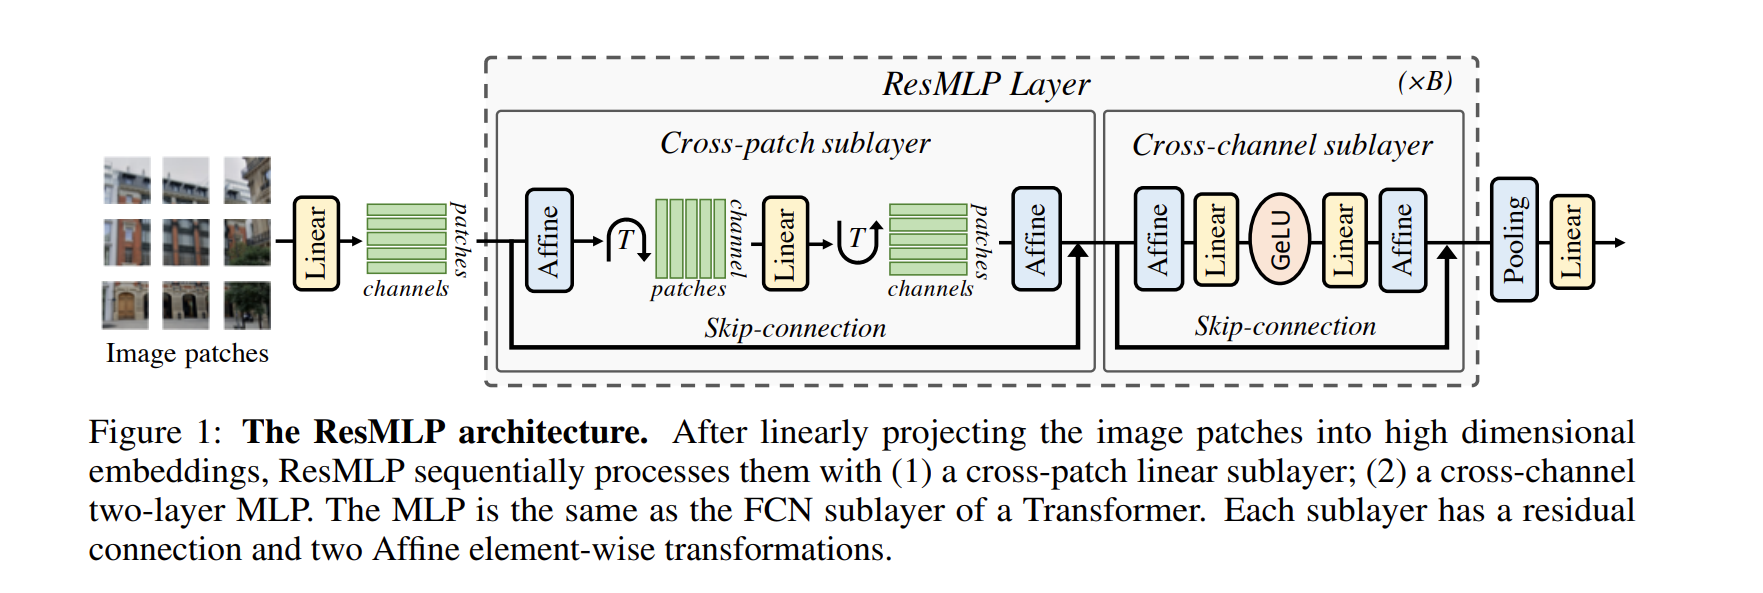

The ResMLP is a combination of the ResNet and MLP. The ResNet is a type of neural network that uses residual connections to skip one or more layers. This helps to solve the vanishing gradient problem and allows the network to learn more complex patterns. The MLP is a type of feedforward neural network that consists of multiple layers of neurons. The ResMLP combines the best of both worlds by using residual connections to skip layers in an MLP architecture.

In [138]:
# implement affine transformation in order to change the input data dimension
class Affine(nn.Module):
    '''
    Arg:
    dim: the dimension of the input data
    self.alpha: linear parameter
    self.beta: offset parameter
    return alpha * x + beta
    '''
    def __init__(self, dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def forward(self, x):
        return self.alpha * x + self.beta

# implement the cross-patch sublayer(in the middle of the figure)
class CrossPatchSublayer(nn.Module):
    def __init__(self, num_patches, hidden_dim):
        super().__init__()
        self.linear = nn.Linear(num_patches, num_patches)
        self.affine = Affine(hidden_dim)
        
    def forward(self, x):
        # we change the dimension of the input data and then use the linear layer to change the data
        x = self.linear(x.transpose(1, 2)).transpose(1, 2)
        return self.affine(x)
# implement the cross-channel sublayer(in the last of the figure)
class CrossChannelSublayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            # GELU activation function
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.affine = Affine(hidden_dim)
        
    def forward(self, x):
        return self.affine(self.mlp(x))
# implement the ResMLP layer, which is the combination of the cross-patch sublayer and the cross-channel sublayer
class ResMLPLayer(nn.Module):
    def __init__(self, num_patches, hidden_dim):
        super().__init__()
        self.cross_patch = CrossPatchSublayer(num_patches, hidden_dim)
        self.cross_channel = CrossChannelSublayer(hidden_dim)
        
    def forward(self, x):
        # Cross-patch sublayer with skip connection
        x = x + self.cross_patch(x)
        # Cross-channel sublayer with skip connection
        x = x + self.cross_channel(x)
        return x

# implement the ResMLP model using the ResMLP layer and the pooling layer
class ResMLP(nn.Module):
    def __init__(self, in_channels, image_size, patch_size, hidden_dim, num_layers, num_classes):
        super(ResMLP, self).__init__()
        # step 1: calculate the number of patches
        num_patches = (image_size // patch_size) ** 2
        # step 2: image patching
        self.patch_embed = nn.Conv2d(in_channels, hidden_dim, kernel_size=patch_size, stride=patch_size)
        # step 3: position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, hidden_dim, num_patches))
        # step 4: Repeat ResMLP layers
        self.layers = nn.Sequential(*[ResMLPLayer((image_size // patch_size) ** 2, hidden_dim) for _ in range(num_layers)])
        # step 5: pooling layer
        self.pooling = nn.AdaptiveAvgPool1d(1)
        # step 6: final linear layer
        self.final_linear = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embed(x)
        # print("original shape",x.shape)
        x = x.flatten(2)  
        # print("after_flatten", x.shape)
        # x = x.transpose(1, 2) 
        # print("afer transpose",x.shape)
        # print("pos_embed", self.pos_embed.shape)
        x = x + self.pos_embed
        x = x.transpose(1, 2) 
        x = self.layers(x)
        x = self.pooling(x.transpose(1, 2)).flatten(1)
        x = self.final_linear(x)
        return x
    
    # save the model
    def save(self, path):
        torch.save(self.state_dict(), path)

    # load the model
    def load(self, path):
        self.load_state_dict(torch.load(path))

    # train the model
    def train_model(self, device, train_loader, optimizer, epoch):
        self.train()
        criterion = nn.CrossEntropyLoss()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = self(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # test the model
    def test_model(self, device, test_loader):
        self.eval()
        criterion = nn.CrossEntropyLoss(reduction='sum')
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = self(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
        return accuracy, test_loss

In [139]:
x_train.shape

(60000, 28, 28)

In [140]:
# add a additional dimension to the input data in order to fit the model
# the mnist is grey image, so the input channel is 1
# if we use CIFAR-10, the input channel is 3
x_train = x_train.reshape(-1, 1, 28, 28).astype(np.float32)  
x_test = x_test.reshape(-1, 1, 28, 28).astype(np.float32)    
# create the train and test dataset
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train).long() 
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test).long()
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [141]:
# show the results using results variable
def show_results(results):
    results = np.array(results)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(results[:, 0], results[:, 1])
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Epoch-Accuracy')
    ax[1].plot(results[:, 0], results[:, 2])
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Epoch-Loss')
    plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 36.208786


Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.689510
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.452545
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.344972
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.185923

Test set: Average loss: 0.2610, Accuracy: 9166/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.302772
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.161334
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.329666
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.204882
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.282743

Test set: Average loss: 0.1674, Accuracy: 9508/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.082729
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.184805
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.170401
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.234652
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.127175

Test set: Average loss: 0.1332, Accuracy: 9594/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.077199
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.085700
Train Epoch: 4 [25600/60000 (43%

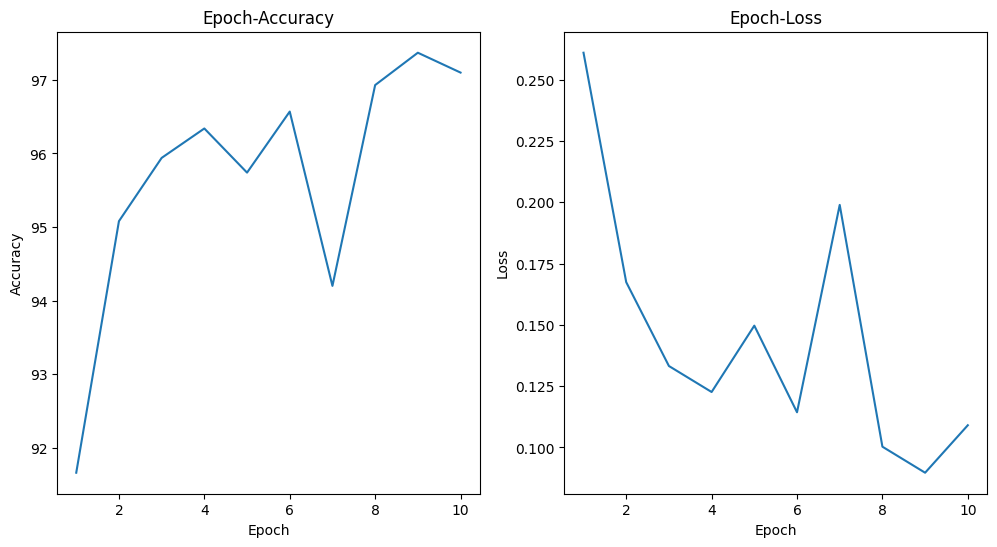

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create the ResMLP model
model = ResMLP(in_channels=1, image_size=28, patch_size=4, hidden_dim=128, num_layers=4, num_classes=10)
model = model.to(device)

# choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
# declear a variable to store the results
results = []
for epoch in range(1, num_epochs + 1):
    model.train_model(device, train_loader, optimizer, epoch)
    accuracy, loss = model.test_model(device, test_loader)
    results.append((epoch, accuracy, loss))  

# show the epoch-accuracy figure and the epoch-loss figure
show_results(results)

# save the model
model.save('ResMLP.pth')

In [143]:
# calculate the maximum accuracy
max_acc = 0
for epoch, accuracy, loss in results:
    if accuracy > max_acc:
        max_acc = accuracy
print('Maximum Accuracy:', max_acc)

Maximum Accuracy: 97.37


## result analysis

we can see that the maximum accuracy is 97.37, is better than MLP.

In [149]:
# show the architecture of the model
print(model)

ResMLP(
  (patch_embed): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
  (layers): Sequential(
    (0): ResMLPLayer(
      (cross_patch): CrossPatchSublayer(
        (linear): Linear(in_features=49, out_features=49, bias=True)
        (affine): Affine()
      )
      (cross_channel): CrossChannelSublayer(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
        (affine): Affine()
      )
    )
    (1): ResMLPLayer(
      (cross_patch): CrossPatchSublayer(
        (linear): Linear(in_features=49, out_features=49, bias=True)
        (affine): Affine()
      )
      (cross_channel): CrossChannelSublayer(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
        (a

In [159]:
# try the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 170498071/170498071 [00:18<00:00, 9318849.41it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


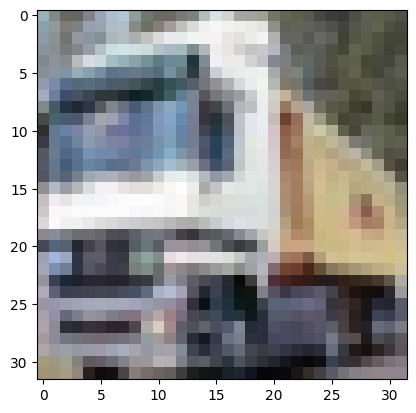

truck


In [164]:
# label the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show the second image and the label
image, label = train_dataset[1]
image = image.permute(1, 2, 0)
plt.imshow(image)
plt.show()
print(classes[label])

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.333682

Test set: Average loss: 1.5536, Accuracy: 4340/10000 (43%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.532737

Test set: Average loss: 1.3751, Accuracy: 4982/10000 (50%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.275792

Test set: Average loss: 1.2810, Accuracy: 5404/10000 (54%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.179572

Test set: Average loss: 1.2077, Accuracy: 5658/10000 (57%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.150300

Test set: Average loss: 1.1915, Accuracy: 5706/10000 (57%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.169279

Test set: Average loss: 1.1673, Accuracy: 5778/10000 (58%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.101312

Test set: Average loss: 1.1158, Accuracy: 5969/10000 (60%)

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.934088

Test set: Average loss: 1.1070, Accuracy: 6010/10000 (60%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.959624

Test set: Average loss: 1.0858, Accuracy: 6103/10000 (61%)

Train Epoch: 10 [0/50000 (0%)]	Loss: 0.829787


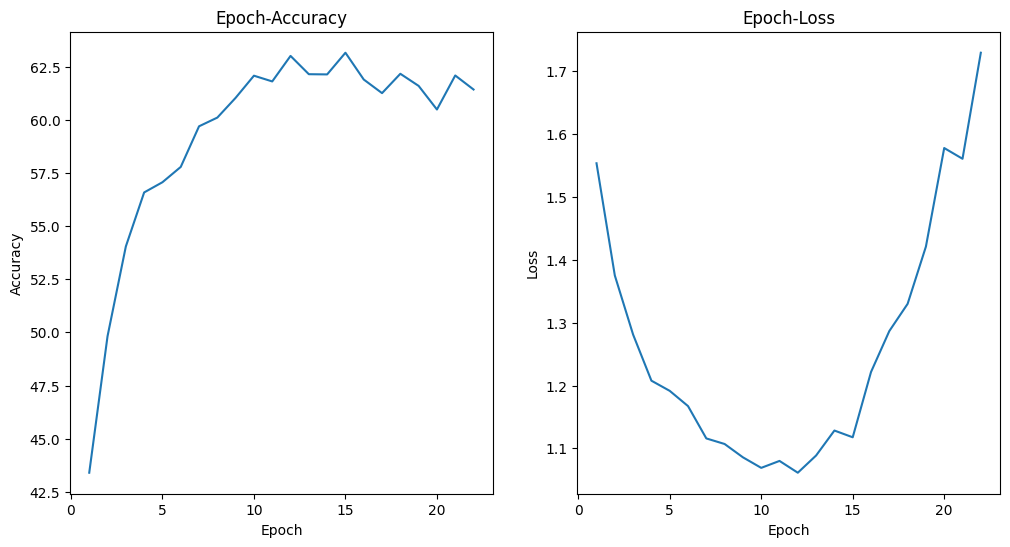

In [168]:
# use the ResMLP model to train the CIFAR-10 dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResMLP(in_channels=3, image_size=32, patch_size=4, hidden_dim=256, num_layers=6, num_classes=10)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
results = []
min_loss = 1000
times = 0
for epoch in range(1, num_epochs + 1):
    model.train_model(device, train_loader, optimizer, epoch)
    accuracy, loss = model.test_model(device, test_loader)
    if loss < min_loss:
        min_loss = loss
        times = 0
    else:
        times = times + 1
        if times > 10:
            break
    results.append((epoch, accuracy, loss))

# show the epoch-accuracy figure and the epoch-loss figure
show_results(results)

In CIFAR-10, the accuray is low. The reason is that the CIFAR-10 is more complex than MNIST, and the ResMLP is not complex enough to solve the problem. We can try to use a more complex model to solve the problem. And we can see that the training_set loss is always much lower than testing_set loss, which means the model is overfitting. We can try to use some methods to solve the problem, such as dropout, L1 regularization, L2 regularization, and so on. But in this lab, we only use the ResMLP to solve the problem.